# Online Retail

This notebook aims to analyze the impact of a discount strategy on product sales using the "Online Retail" dataset. The dataset contains transactional data from an online retail company based in the United Kingdom, spanning from December 2010 to December 2011. The dataset includes information about the invoices, products, quantities, prices, and customer details.

### Goal: apply Statistics to analyze Online Retail dataset.
The primary goal of this analysis is to evaluate the effectiveness of a discount strategy on product sales.

#### Dataset columns:
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invoice date and time. Numeric, the day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

In [97]:
#Import common libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Exploration and Cleaning

In [98]:
#Read the dataset
data = pd.read_csv('OnlineRetail.csv',encoding = "ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [100]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


2 columns has missing values: Description and CustomerID. 

Columns types: 5 object, 2 float and 1 int64. CustomerID could be a object instead of float.

Quantity and UnitPrice with negative values.

### Missing Values

In [101]:
#Analyze missing values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [102]:
data[data['Description'].isnull()]['CustomerID'].isna().sum()

1454

All rows with missing Description has missing CustomerID too.

In [103]:
#Missing values ratio per column. 
data.isnull().sum()/data.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Description has 0.27% of missing values.
CustomerID almost 25% of missing values.

In [104]:
# I'll see if I can fill CustomerID given the InvoiceNo
invoice_customer_count = data.groupby('InvoiceNo')['CustomerID'].nunique()
inconsistent_invoice_customer_count = invoice_customer_count[invoice_customer_count > 1]
inconsistent_invoice_customer_count.shape[0]

0

The result confirms that there are no cases with the same InvoiceNo but with a different amount of CustomerID. This means that all InvoiceNos have a single CustomerID value (or all NaNs).
I have no choise but to drop them.

In [105]:
# Remove CustomerID with missing values
data = data.dropna(subset=['CustomerID'])
data.isnull().sum()/data.shape[0]*100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

All missing Description were droped too.

In [106]:
#Analyze the dataset again after removing missing values
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


There is negative Quantity? Zero value in UnitePrice? (Negative values in UnitPrice are gone).
CustomerID a numeric value?

In [107]:
data[data.Quantity < 0]["Quantity"].count()

8905

Negative Quantity may be because orders were cancelled. They will not contribute to my analysis, so I will drop them.

In [108]:
#Drop rows with negative quantity
data = data[data.Quantity >= 0]
data.shape

(397924, 8)

In [109]:
#Rows with UnitPrice = 0
display(data[data.UnitPrice == 0].sort_values("StockCode"))
print(len(data[data.UnitPrice == 0]))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
420404,572893,21208,PASTEL COLOUR HONEYCOMB FAN,5,10/26/2011 14:36,0.0,18059.0,United Kingdom
314748,564651,21786,POLKADOT RAIN HAT,144,8/26/2011 14:19,0.0,14646.0,Netherlands
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,3/30/2011 12:45,0.0,13113.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,3/23/2011 10:25,0.0,13239.0,United Kingdom
436597,574175,22065,CHRISTMAS PUDDING TRINKET POT,12,11/3/2011 11:47,0.0,14110.0,United Kingdom
454464,575579,22089,PAPER BUNTING VINTAGE PAISLEY,24,11/10/2011 11:49,0.0,13081.0,United Kingdom
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,4/4/2011 14:42,0.0,14410.0,United Kingdom
279324,561284,22167,OVAL WALL MIRROR DIAMANTE,1,7/26/2011 12:24,0.0,16818.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107.0,United Kingdom


40


There are 40 products with price equal to Zero. Lets analyze if we can impute them given the SotckCode.

In [110]:
# How many products have all prices equal to 0
data.groupby('StockCode')['UnitPrice'].apply(lambda x: (x == 0).all()).sum()


0

I'm going to impute 0 values with the median of the products price.

In [111]:
#Function to impute median price
def impute_median_price(group):
    non_zero_prices = group[group['UnitPrice'] > 0]['UnitPrice']
    if not non_zero_prices.empty:
        median_price = non_zero_prices.median()
        group.loc[group['UnitPrice'] == 0, 'UnitPrice'] = median_price
    return group

In [112]:
#Impute median price for UnitPrice = 0
data = data.groupby('StockCode', group_keys=False).apply(impute_median_price).copy()


In [113]:
#Is there any UnitPrice = 0?
print(len(data[data.UnitPrice == 0]))

0


In [114]:
#3 Countrys with more purchases
data.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(3)

Country
United Kingdom    4269472
Netherlands        200937
EIRE               140525
Name: Quantity, dtype: int64

### Casting columns

In [115]:
#Cast the InvoiceDate column to datetime and CostumerID to str
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['CustomerID'] = data['CustomerID'].astype('str')

### Identify and remove duplicates

In [116]:
#Check for duplicates
data.duplicated(keep=False).sum()

10003

In [117]:
# Visually inspect some of the duplicated rows
duplicated = data[data.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode'])
duplicated.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
565,536412,21448,12 DAISY PEGS IN WOOD BOX,2,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


In [118]:
#Drop duplicates keep first
data = data.drop_duplicates(keep='first')
data.duplicated().sum()

0

## Basic Descriptive Statistics

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392731 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392731 non-null  object        
 1   StockCode    392731 non-null  object        
 2   Description  392731 non-null  object        
 3   Quantity     392731 non-null  int64         
 4   InvoiceDate  392731 non-null  datetime64[ns]
 5   UnitPrice    392731 non-null  float64       
 6   CustomerID   392731 non-null  object        
 7   Country      392731 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [120]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,392731.000000,392731,392731.000000
mean,13.153746,2011-07-10 19:14:55.810414848,3.125919
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 12:02:00,1.950000
75%,12.000000,2011-10-20 12:53:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,181.588650,NaN,22.240751


In [121]:
#Total number of transactions
print('Number of transactions: ', data['InvoiceNo'].nunique())
#Total products sold
print ('Number of products sold: ', data['Quantity'].sum())
#Total number of products
print('Number of products: ', data['StockCode'].nunique())
#Total number of customers
print('Number of customers: ', data['CustomerID'].nunique())
#Averange price
print('Average price: ', data['UnitPrice'].mean())

Number of transactions:  18536
Number of products sold:  5165884
Number of products:  3665
Number of customers:  4339
Average price:  3.1259194334035256


In [122]:
#Total revenue
data['Total_Price'] = data['Quantity'] * data['UnitPrice']
print('Total revenue: ', round(data['Total_Price'].sum(),2))

Total revenue:  8900655.14


In [123]:
#3 Countrys with more revenue
data.groupby('Country')['Total_Price'].sum().sort_values(ascending=False).head(3)

Country
United Kingdom    7296046.805
Netherlands        286226.820
EIRE               265889.160
Name: Total_Price, dtype: float64

## A/B Testing Setup

I'm going to test a marketing strategy where a discount is offered to a subset of customers to see if it increases the total revenue.
Task:
- Randomly assign customers to two groups: Group A (Control) and Group B (Treatment).
- Ensure the groups are of similar size.
- Calculate the total revenue for each group.

In [124]:
#Identify unique customers
customers = data['CustomerID'].unique()
customers.shape

(4339,)

In [125]:
#Randomly divide the customers in groups A and B in equal proportions
np.random.seed(42)
# Randomly divide the customers into groups A and B in equal proportions
np.random.seed(42)
groupA = np.random.choice(customers, size=len(customers)//2, replace=False)
groupB = customers[~np.isin(customers, groupA)]

# Add a column indicating group to the original dataset
data['Group'] = 'A'
data.loc[data['CustomerID'].isin(groupB), 'Group'] = 'B'

In [126]:
print(len(groupA), len(groupB))

2169 2170


In [127]:
#Total revenue per group
print(data.groupby('Group')['Total_Price'].sum())

Group
A    4102872.731
B    4797782.404
Name: Total_Price, dtype: float64


## Refined Statistical Testing

Task:
- Calculate the average revenue per customer for each group.
- Perform an independent samples t-test on the average revenue per customer.
- Interpret the results: Determine whether to reject the null hypothesis based on the p-value.

In [128]:
#t-test on average revenue per customer
from scipy import stats

# Calculate the total revenue for each group
total_revenue_A = data[data['Group'] == 'A']['Total_Price'].sum()
total_revenue_B = data[data['Group'] == 'B']['Total_Price'].sum()

# Calculate the average revenue per customer for each group
avg_revenue_per_customer_A = total_revenue_A / data[data['Group'] == 'A']['CustomerID'].nunique()
avg_revenue_per_customer_B = total_revenue_B / data[data['Group'] == 'B']['CustomerID'].nunique()

# Calculate total revenue per customer
groupA_revenue = data[data['Group'] == 'A'].groupby('CustomerID')['Total_Price'].sum()
groupB_revenue = data[data['Group'] == 'B'].groupby('CustomerID')['Total_Price'].sum()

# Perform t-test 
t_stat, p_value = stats.ttest_ind(groupA_revenue, groupB_revenue)

# Results
print("Total revenue for Group A: ", total_revenue_A)
print("Total revenue for Group B: ", total_revenue_B)
print("Average revenue per customer for Group A: ", avg_revenue_per_customer_A)
print("Average revenue per customer for Group B: ", avg_revenue_per_customer_B)
print("T-statistic: ", t_stat)
print("P-value: ", p_value)

Total revenue for Group A:  4102872.731
Total revenue for Group B:  4797782.404000001
Average revenue per customer for Group A:  1891.5964642692486
Average revenue per customer for Group B:  2210.959633179724
T-statistic:  -1.1692720092714073
P-value:  0.24235831531536864


pvalue = 0.24. That meand that null hypotesis is correct and that there is no significant difference in the total revenue between Group A and Group B.

## Segmentation Analysis

Task:
- Segment customers by country.
- Calculate the average revenue per customer within each country for both groups.
- Perform an independent samples t-test for each country to determine if the treatment had a significant impact within any specific segment.

In [129]:
#Segment by group and country
data.groupby(['Group', 'Country'])['Total_Price'].sum().unstack().fillna(0)

Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
Group,,,,,,,,,,,,,,,,,,,,,
A,11970.00,7672.31,0.0,26969.06,0.0,585.80,12974.94,6904.74,826.74,17510.23,...,0.00,145.92,0.00,29431.13,1486.85,40576.21,1849.47,0.00,3509572.711,2130.59
B,127433.01,2526.37,548.4,14227.28,1143.6,3080.58,7465.60,6598.11,0.00,1445.11,...,1003.81,0.00,21279.29,32174.18,36880.98,15876.24,1730.92,1902.28,3786474.094,530.18


In [130]:
#Averange revenue per customer per country
data.groupby(['Group', 'Country'])['Total_Price'].sum().unstack().fillna(0)/data.groupby(['Group', 'Country'])['CustomerID'].nunique()

Group            A                                                            \
Country  Australia    Austria      Belgium   Canada Channel Islands   Cyprus   
Group                                                                          
A         2394.000  959.03875  1926.361429   292.90        2594.988  2301.58   
B        25486.602  315.79625  1016.234286  1540.29        1493.120  2199.37   

Group                                                              ...  \
Country Czech Republic      Denmark       EIRE European Community  ...   
Group                                                              ...   
A               826.74  2918.371667  144337.87            1300.25  ...   
B                 0.00   240.851667  121551.29               0.00  ...   

Group          B                                                        \
Country Portugal      RSA Singapore        Spain    Sweden Switzerland   
Group                                                                    
A        5036.33     0.00      0.00  2452.594167   297.370    4057.621   
B         526.31  1003.81  21279.29  2681.181667  7376.196    1587.624   

Group                                                             
Country      USA United Arab Emirates United Kingdom Unspecified  
Group                                                             
A        924.735                 0.00    1791.512359     2130.59  
B        865.460               951.14    1932.860691      530.18  

[2 rows x 62 columns]

In [131]:
#Perform an independent samples t-test for each country 
p_values = []
for country in data['Country'].unique():
    groupA_revenue = data[(data['Group'] == 'A') & (data['Country'] == country)]['Total_Price']
    groupB_revenue = data[(data['Group'] == 'B') & (data['Country'] == country)]['Total_Price']
    t_stat, p_value = stats.ttest_ind(groupA_revenue, groupB_revenue)
    p_values.append((country, p_value))
p_values

[('United Kingdom', 0.7107351094653491),
 ('France', 0.14648234025864446),
 ('Australia', 2.824637225275828e-41),
 ('Netherlands', 9.12074228729077e-22),
 ('Germany', 0.04368188138784697),
 ('Norway', 0.0007990283524635785),
 ('EIRE', 1.306028007636782e-109),
 ('Switzerland', 0.3450080858128618),
 ('Spain', 3.4148880850334925e-08),
 ('Poland', 7.450775581616187e-07),
 ('Portugal', 0.5303450342793328),
 ('Italy', 0.27282499093192447),
 ('Belgium', 7.435502576092599e-06),
 ('Lithuania', nan),
 ('Japan', 0.9814462296227671),
 ('Iceland', nan),
 ('Channel Islands', 0.04193550316473969),
 ('Denmark', 0.07877860848683435),
 ('Cyprus', 0.010161378066599306),
 ('Sweden', 3.64830372931084e-07),
 ('Finland', 1.5288303743123533e-08),
 ('Austria', 0.0006763510972241027),
 ('Greece', 2.155860315803731e-27),
 ('Singapore', nan),
 ('Lebanon', nan),
 ('United Arab Emirates', nan),
 ('Israel', nan),
 ('Saudi Arabia', nan),
 ('Czech Republic', nan),
 ('Canada', 0.0024344884041164042),
 ('Unspecified', 0

In [132]:
#Loop through each country and check if the p-value is less than 0.05
p_values = [(country, p_value) for country, p_value in p_values if p_value < 0.05]

#Print the results
for country, p_value in p_values:
    print(f"Country: {country}, P-value: {p_value}")

Country: Australia, P-value: 2.824637225275828e-41
Country: Netherlands, P-value: 9.12074228729077e-22
Country: Germany, P-value: 0.04368188138784697
Country: Norway, P-value: 0.0007990283524635785
Country: EIRE, P-value: 1.306028007636782e-109
Country: Spain, P-value: 3.4148880850334925e-08
Country: Poland, P-value: 7.450775581616187e-07
Country: Belgium, P-value: 7.435502576092599e-06
Country: Channel Islands, P-value: 0.04193550316473969
Country: Cyprus, P-value: 0.010161378066599306
Country: Sweden, P-value: 3.64830372931084e-07
Country: Finland, P-value: 1.5288303743123533e-08
Country: Austria, P-value: 0.0006763510972241027
Country: Greece, P-value: 2.155860315803731e-27
Country: Canada, P-value: 0.0024344884041164042
Country: Unspecified, P-value: 0.000450924330737151
Country: USA, P-value: 8.832246547549074e-06


In [133]:
#Lets look at those countries that have a p-value less than 0.05
data[data['Country'].isin([country for country, p_value in p_values])].groupby(['Country', 'Group'])['Total_Price'].sum().unstack().fillna(0)

Group,A,B
Country,,
Australia,11970.00,127433.01
Austria,7672.31,2526.37
Belgium,26969.06,14227.28
Canada,585.80,3080.58
Channel Islands,12974.94,7465.60
Cyprus,6904.74,6598.11
EIRE,144337.87,121551.29
Finland,9123.51,13422.57
Germany,104931.87,123755.98


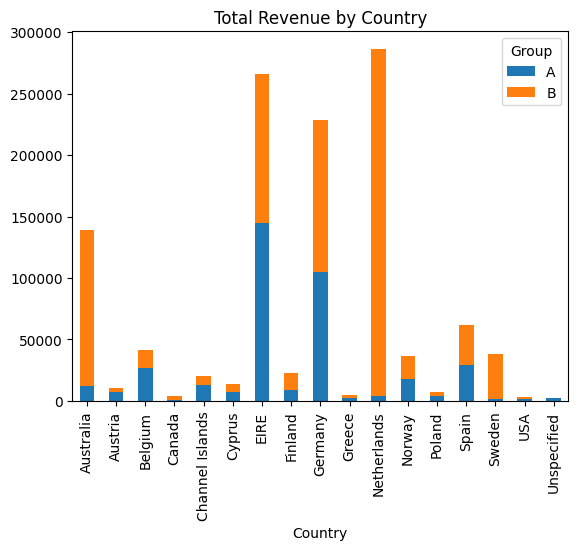

In [134]:
#Plot the results
data[data['Country'].isin([country for country, p_value in p_values])].groupby(['Country', 'Group'])['Total_Price'].sum().unstack().fillna(0).plot(kind='bar', stacked=True)
plt.title('Total Revenue by Country')
plt.show()

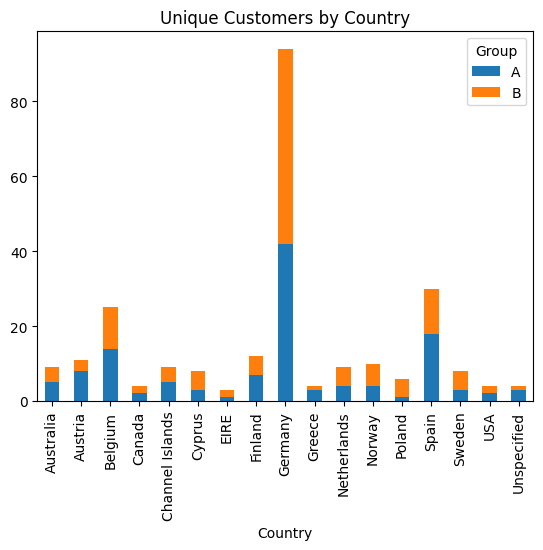

In [135]:
#Plot the unique customers in each group in each country with p-value less than 0.05
data[data['Country'].isin([country for country, p_value in p_values])].groupby(['Country', 'Group'])['CustomerID'].nunique().unstack().fillna(0).plot(kind='bar', stacked=True)
plt.title('Unique Customers by Country')
plt.show()


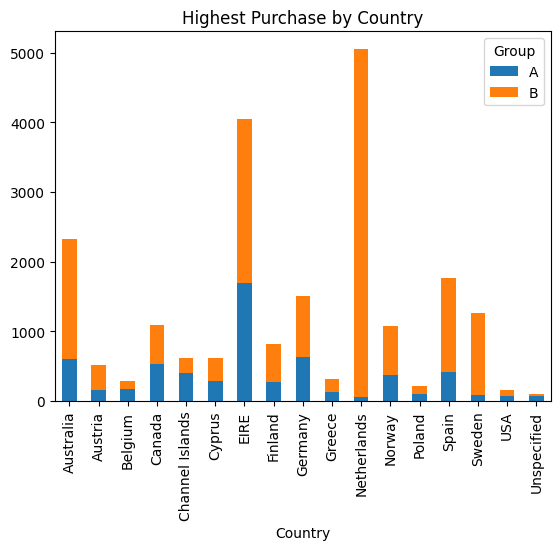

In [136]:
#Plot the highest purchase (maximum Total_Price) for each group in each country.
data[data['Country'].isin([country for country, p_value in p_values])].groupby(['Country', 'Group'])['Total_Price'].max().unstack().fillna(0).plot(kind='bar', stacked=True)
plt.title('Highest Purchase by Country')
plt.show()

#### Analysis of Findings
1. Total Revenue by Country:

- Significant differences in total revenue between Group A and Group B in several countries, such as Australia, the Netherlands, Spain and Sweden.

2. Unique Customers by Country:

- Similar number of unique customers in both groups, indicating that the revenue differences are likely due to a few high-value purchases rather than a large number of small purchases.

3. Highest Purchase by Country:

- The highest purchase amounts in each group for the significant countries. Large individual purchases likely contribute to the differences in total revenue.

I'm going to analyze this countries closer.

In [137]:
#Filter the data for Australia, Netherlands, Spain and Sweden.
anss = data[data.Country.isin(['Australia', 'Netherlands', 'Spain', 'Sweden'])]
anss.shape

(6477, 10)

In [138]:
#Identify the customer that did the biggest purchase of every anss country
anss.groupby(['CustomerID', 'Country'])['Total_Price'].sum().nlargest(4)


CustomerID  Country    
14646.0     Netherlands    280986.50
12415.0     Australia      125838.77
17404.0     Sweden          31906.82
12540.0     Spain           13400.24
Name: Total_Price, dtype: float64

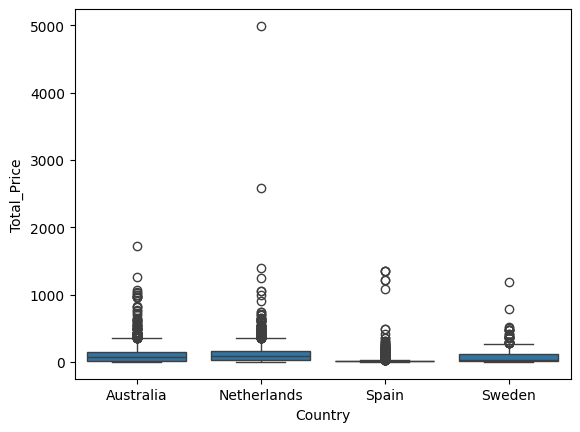

In [139]:
#Boxplot of Total_Price for anss countrys to see if there are any outliers
sns.boxplot(x='Country', y='Total_Price', data=anss)
plt.show()

Outliers: There are notable high-value purchases in each of these countries.

In detail:
- Netherlands: Customer ID 14646.0 with a total purchase of $280,986.50.
- Australia: Customer ID 12415.0 with a total purchase of $125,838.77.
- Sweden: Customer ID 17404.0 with a total purchase of $31,906.82.
- Spain: Customer ID 12540.0 with a total purchase of $13,400.24.

These large purchases likely contribute significantly to the total revenue differences observed between Group A and Group B.

In [140]:
# Look into the individual transactions made by these customers to understand their purchasing behavior.
high_purchasers = anss.groupby('CustomerID')['Total_Price'].sum().nlargest(4).index

#Transform hight_purchasers into a dictionary with the country as the key and the customerID as the value
high_purchasers = dict(zip(['Netherlands', 'Australia', 'Sweden', 'Spain'], high_purchasers))
print(high_purchasers)

{'Netherlands': '14646.0', 'Australia': '12415.0', 'Sweden': '17404.0', 'Spain': '12540.0'}


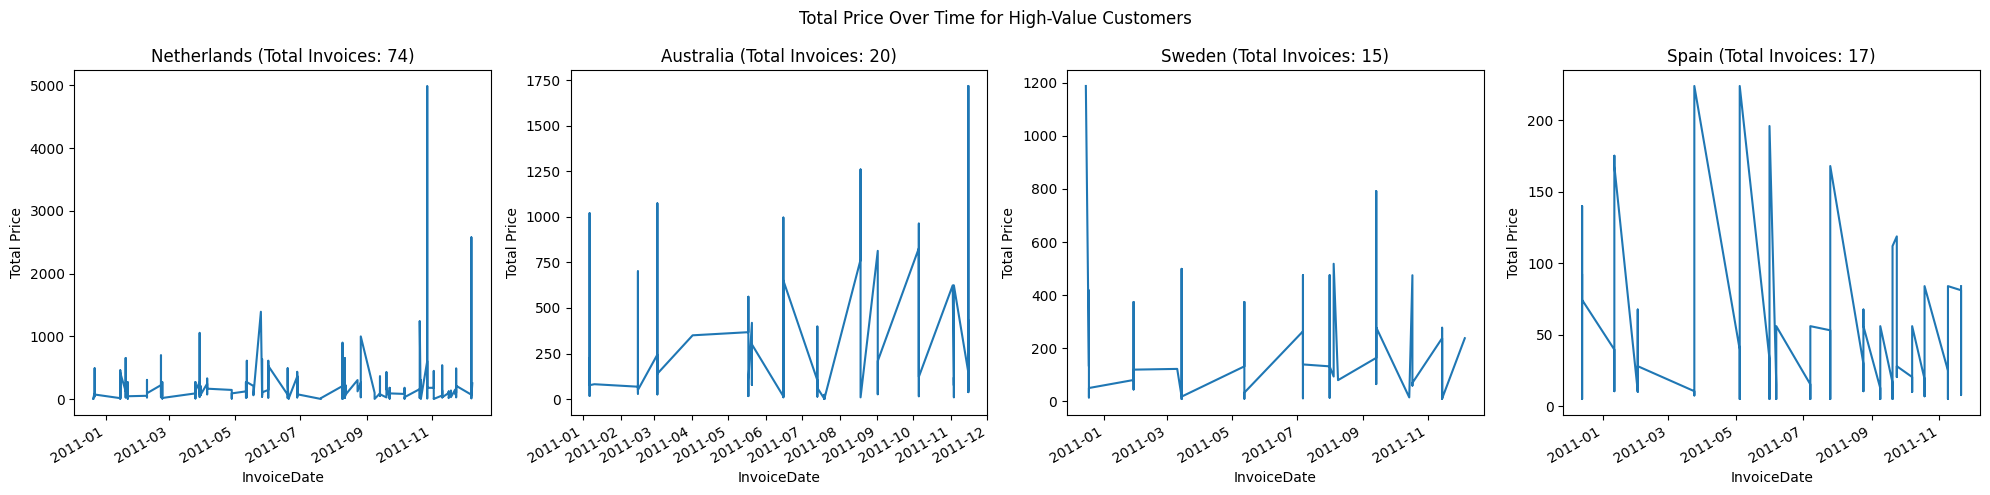

In [141]:
# Create subplots for each country
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Total Price Over Time for High-Value Customers')

# Plot Total_Price for each high-value customer over time and include total number of InvoiceDate entries in the title
for ax, (country, customer_id) in zip(axs, high_purchasers.items()):
    country_data = data[data['CustomerID'] == customer_id]
    num_invoices = country_data['InvoiceDate'].nunique()
    country_data.plot(x='InvoiceDate', y='Total_Price', ax=ax, title=f"{country} (Total Invoices: {num_invoices})", legend=False)
    ax.set_ylabel('Total Price')

# Show the plots
plt.tight_layout()
plt.show()

#### Observations:
- Netherlands: The high-value customer made numerous high-value purchases frequently, indicating consistent high spending. Two very-high-value purchases.

- Australia: The high-value customer made several significant purchases, with a few very large transactions spread over time.

- Spain: The high-value customer had fewer, but still notable, large transactions.

- Sweden: The high-value customer made a few significant purchases, similar to the pattern observed in Spain.

In [142]:
# Top Products. I want to know which products are the most popular for these big customers. Description, Total Quantity and Total Price.
for country, customer_id in high_purchasers.items():
    country_data = data[data['CustomerID'] == customer_id]
    product_analysis = country_data.groupby('Description')[['Total_Price', 'Quantity']].sum().sort_values(by='Total_Price', ascending=False)
    print(f"Top products in {country}:\n", product_analysis.head(10))

Top products in Netherlands:
                                      Total_Price  Quantity
Description                                               
RABBIT NIGHT LIGHT                       9568.48      4801
ROUND SNACK BOXES SET OF4 WOODLAND       7956.00      3120
SPACEBOY LUNCH BOX                       7415.40      4492
DOLLY GIRL LUNCH BOX                     6758.40      4096
ROUND SNACK BOXES SET OF 4 FRUITS        4039.20      1584
JUMBO BAG RED RETROSPOT                  3468.00      2000
RED TOADSTOOL LED NIGHT LIGHT            3459.60      2376
REGENCY CAKESTAND 3 TIER                 3153.60       288
5 HOOK HANGER RED MAGIC TOADSTOOL        2923.20      2016
JUMBO BAG WOODLAND ANIMALS               2629.00      1500
Top products in Australia:
                                    Total_Price  Quantity
Description                                             
RABBIT NIGHT LIGHT                     2749.44      1536
SET OF 6 SPICE TINS PANTRY DESIGN      1987.20       576
REGENC

- Netherlands:
The top product is "RABBIT NIGHT LIGHT" with significant total purchases both in terms of quantity and total price.
High demand for lunch boxes and snack boxes.

- Australia:
Similar high demand for "RABBIT NIGHT LIGHT" as in the Netherlands.
Varied high-value purchases including spice tins, cake tins, and lunch boxes.

- Sweden:
"MINI PAINT SET VINTAGE" stands out with the highest quantity and total price.
Consistent interest in cake tins and heart-shaped petit four cases.

- Spain:
The top product is "POSTAGE", which might indicate shipping charges or a specific product related to postage.
Other products include bird ornaments, cake stands, and plant holders.

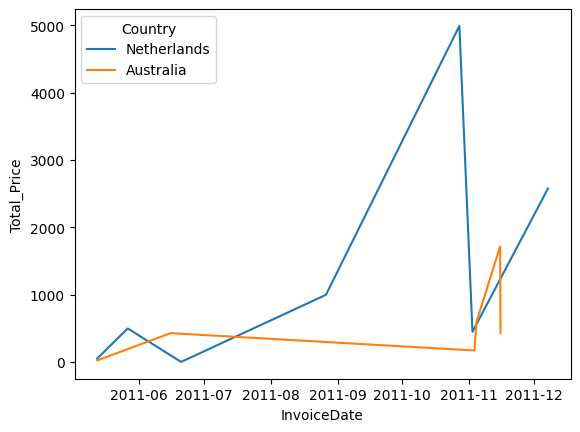

In [143]:
#Analyze the purchase of Rabbit Night Light in the Netherlands and Australia along the time.
na = data[data['Country'].isin(['Netherlands', 'Australia'])]
na = na[na['Description'] == 'RABBIT NIGHT LIGHT']

#Plot the rabbit night light purchases in the Netherlands and Australia in different colors
sns.lineplot(x='InvoiceDate', y='Total_Price', hue='Country', data=na)
plt.show()

- Netherlands:
There is a significant spike in purchases around October 2011.
The purchases appear to be more sporadic but with higher total prices.

- Australia:
Purchases are more consistent over time, with a noticeable increase in November 2011.
The total purchase amounts are generally lower compared to the Netherlands but more steady.

## Outliers detection.

In [144]:
#Detect outliers using 3 sigma rule
upper = data.groupby('Country')['Total_Price'].mean() + 3 * data.groupby('Country')['Total_Price'].std()
lower = data.groupby('Country')['Total_Price'].mean() - 3 * data.groupby('Country')['Total_Price'].std()

bounds = pd.DataFrame({
    'upper': upper,
    'lower': lower
})

# Function to identify outliers
def is_outlier(row):
    country = row['Country']
    total_price = row['Total_Price']
    upper_bound = bounds.at[country, 'upper']
    lower_bound = bounds.at[country, 'lower']
    return total_price < lower_bound or total_price > upper_bound

# Create a new column 'is_outlier'
data['is_outlier'] = data.apply(is_outlier, axis=1)

In [145]:
# Filtering out the outliers
outliers = data[data['is_outlier']]
outliers.shape

(869, 11)

In [146]:
#Count outliers per country
outliers.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)

Country
United Kingdom          273
Germany                 140
EIRE                    113
Switzerland              52
Belgium                  40
France                   26
Australia                25
Spain                    21
Norway                   21
Netherlands              19
Finland                  18
Denmark                  16
Channel Islands          14
Cyprus                   12
Italy                    11
Poland                   10
Sweden                    9
Austria                   8
Portugal                  7
Singapore                 5
USA                       4
Iceland                   4
Israel                    3
Japan                     3
Unspecified               3
Malta                     2
Canada                    2
Greece                    1
European Community        1
RSA                       1
Lithuania                 1
Lebanon                   1
Brazil                    1
United Arab Emirates      1
Bahrain                   1
Name: Invoic

In [147]:
#Remove outliers
data = data[~data['is_outlier']]

In [148]:
#Save final data
data.to_csv('Online_Retail_Final.csv', index=False)

## A/B Test

In [149]:
#3 Countrys with more revenue
data.groupby('Country')['Total_Price'].sum().sort_values(ascending=False).head(3)

Country
United Kingdom    6485548.365
Netherlands        264570.760
EIRE               205823.730
Name: Total_Price, dtype: float64

In [150]:
#Most purchased products in United Kingdom, Netherlands and EIRE
une = data[data['Country'].isin(['United Kingdom', 'Netherlands', 'EIRE'])]
une.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(4)

Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS    45102
JUMBO BAG RED RETROSPOT              40814
PACK OF 72 RETROSPOT CAKE CASES      28202
ASSORTED COLOUR BIRD ORNAMENT        28132
Name: Quantity, dtype: int64

In [151]:
une.groupby('Description')['Total_Price'].sum().sort_values(ascending=False).head(3)

Description
REGENCY CAKESTAND 3 TIER              99313.00
JUMBO BAG RED RETROSPOT               75378.05
WHITE HANGING HEART T-LIGHT HOLDER    73502.48
Name: Total_Price, dtype: float64

In [152]:
# Most sold products in each country
grouped = une.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()
most_sold_une = grouped.loc[grouped.groupby('Country')['Quantity'].idxmax()]
most_sold_une

,Country,Description,Quantity
1154,EIRE,PACK OF 72 RETROSPOT CAKE CASES,1632
2425,Netherlands,PACK OF 72 RETROSPOT CAKE CASES,4128
6535,United Kingdom,WORLD WAR 2 GLIDERS ASSTD DESIGNS,44286


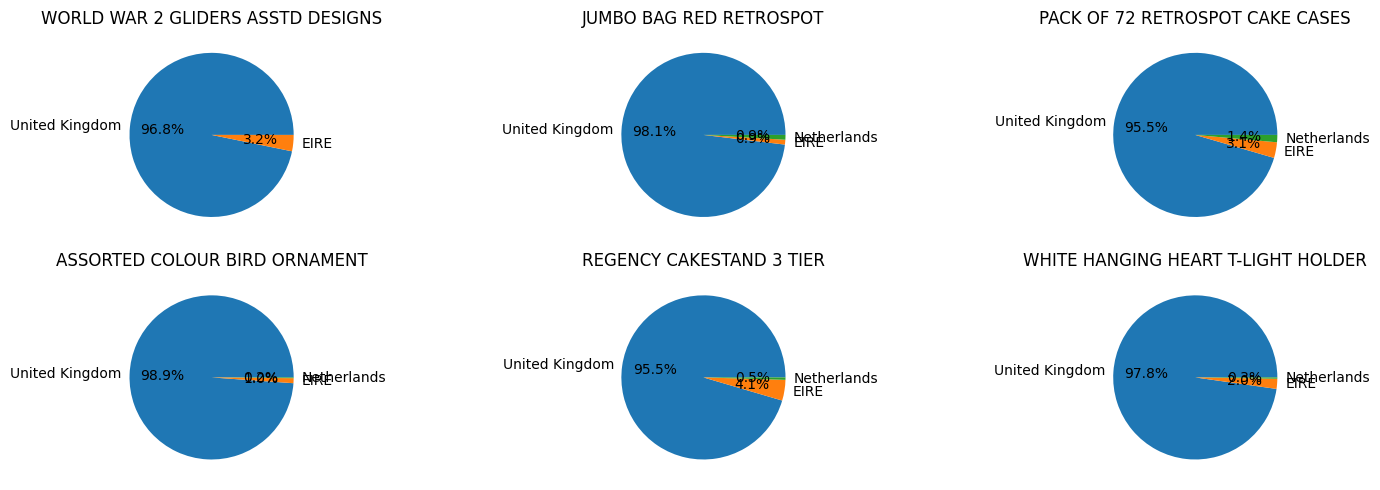

In [153]:
products = ['WORLD WAR 2 GLIDERS ASSTD DESIGNS', 'JUMBO BAG RED RETROSPOT', 'PACK OF 72 RETROSPOT CAKE CASES', 'ASSORTED COLOUR BIRD ORNAMENT', 'REGENCY CAKESTAND 3 TIER', 'WHITE HANGING HEART T-LIGHT HOLDER']

#6 pie plots with the products 
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for ax, product in zip(axs.ravel(), products):
    product_data = une[une['Description'] == product]
    country_counts = product_data['Country'].value_counts()
    ax.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%')
    ax.set_title(product)  

plt.tight_layout()
plt.show()

In [154]:
#Total_Price for these listed products in UK
for product in products:
    product_data = data[(data.Country == 'United Kingdom') | (data.Description == product)]
    print(f"The product '{product}' has a total revenue of ${round(product_data['Total_Price'].sum(),2)} and a total quantity of {product_data['Quantity'].sum()}")
    

The product 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' has a total revenue of $6486996.82 and a total quantity of 3912481
The product 'JUMBO BAG RED RETROSPOT' has a total revenue of $6492860.58 and a total quantity of 3911148
The product 'PACK OF 72 RETROSPOT CAKE CASES' has a total revenue of $6490940.64 and a total quantity of 3918476
The product 'ASSORTED COLOUR BIRD ORNAMENT' has a total revenue of $6489732.72 and a total quantity of 3909883
The product 'REGENCY CAKESTAND 3 TIER' has a total revenue of $6501541.81 and a total quantity of 3908595
The product 'WHITE HANGING HEART T-LIGHT HOLDER' has a total revenue of $6489698.56 and a total quantity of 3908772


### A/B Testing Exercise: Discount on a Popular Product in the UK
Conduct an A/B test to evaluate the effectiveness of a discount on one of the top products in the United Kingdom.

Steps:
- Formulate Hypothesis:
Null Hypothesis (H0): The discount does not significantly increase the total revenue or average revenue per customer for the chosen product.
Alternative Hypothesis (H1): The discount significantly increases the total revenue or average revenue per customer for the chosen product.

- Random Assignment:
Randomly assign customers in the UK to two groups: Group A (Control) and Group B (Treatment).

- Implement the Discount Strategy:
Assume that Group B receives a discount on the chosen product.

- Measure Outcomes:
Calculate total revenue and average revenue per customer for the chosen product in both groups.

- Statistical Analysis:
Perform an independent samples t-test to compare the revenue metrics between the two groups.

- Interpret Results:
Based on the p-value and other statistical measures, decide whether to reject the null hypothesis.

In [155]:
#I'm going to analyze the effect of the discount of 20% in the product 'REGENCY CAKESTAND 3 TIER' in UK.
#My null hypothesis is that the discount is not significant. My alternative hypothesis is that the discount is significant.
product = 'REGENCY CAKESTAND 3 TIER'
country = 'United Kingdom'

In [156]:
#Work only with UK data
uk_df_old = data[data['Country'] == country]
#Remove 'Group' column
uk_df = uk_df_old.drop('Group', axis=1)
uk_df_old.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Group,is_outlier
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,A,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,A,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,A,False


Secordary df with information about the sells of the product in UK after applying the discount

In [157]:
uk_df_new = pd.read_csv('OnlineRetail_Updated.csv',encoding = "ISO-8859-1")

#Create Total_Price column
uk_df_new['Total_Price'] = uk_df_new['Quantity'] * uk_df_new['UnitPrice']

In [158]:
#Explore the new data
uk_df_new.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,1536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/01/2011 08:26,2.55,17088.0,United Kingdom,15.30
1,1536365,71053,WHITE METAL LANTERN,6.0,12/01/2011 08:26,3.39,14393.0,United Kingdom,20.34
2,1536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/01/2011 08:26,2.75,14998.0,United Kingdom,22.00


In [159]:
uk_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487619 entries, 0 to 487618
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    487619 non-null  int64  
 1   StockCode    487619 non-null  object 
 2   Description  487619 non-null  object 
 3   Quantity     487619 non-null  float64
 4   InvoiceDate  487619 non-null  object 
 5   UnitPrice    487619 non-null  float64
 6   CustomerID   487619 non-null  float64
 7   Country      487619 non-null  object 
 8   Total_Price  487619 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 33.5+ MB


In [160]:
print(uk_df_old[uk_df_old.Description == 'REGENCY CAKESTAND 3 TIER'].shape)
print(uk_df_new[uk_df_new.Description == 'REGENCY CAKESTAND 3 TIER'].shape)

(1406, 11)
(1711, 9)


Estan algo desbalanceadas las ventas de los productos. Asi que voy a balancearlo de forma aleatoria para poder comparar.

In [161]:
old_product_sells = uk_df_old[uk_df_old.Description == 'REGENCY CAKESTAND 3 TIER']

#Select 1406 random rows with Description = 'REGENCY CAKESTAND 3 TIER' in the new data
new_product_sells = uk_df_new[uk_df_new.Description == 'REGENCY CAKESTAND 3 TIER'].sample(1406, random_state=42)

print(old_product_sells.shape)
print(new_product_sells.shape)

(1406, 11)
(1406, 9)


In [162]:
#Analyze the total revenue and the total quantity in old and new product sales
print("The revenue of the product REGENCY CAKESTAND 3 TIER without discount was ${}".format(round(old_product_sells['Total_Price'].sum(),2)))
print("The revenue of the product REGENCY CAKESTAND 3 TIER with discount was ${}".format(round(new_product_sells['Total_Price'].sum(),2)))
print("The total quantity of the product REGENCY CAKESTAND 3 TIER without discount was {}".format(old_product_sells['Quantity'].sum()))
print("The total quantity of the product REGENCY CAKESTAND 3 TIER with discount was {}".format(new_product_sells['Quantity'].sum()))

The revenue of the product REGENCY CAKESTAND 3 TIER without discount was $92886.4
The revenue of the product REGENCY CAKESTAND 3 TIER with discount was $138791.12
The total quantity of the product REGENCY CAKESTAND 3 TIER without discount was 7989
The total quantity of the product REGENCY CAKESTAND 3 TIER with discount was 13471.5


In [163]:
#Null Hypothesis: The discount is not significant
#Alternative Hypothesis: The discount is significant

stats.ttest_ind(old_product_sells['Total_Price'], new_product_sells['Total_Price'], equal_var=False)

TtestResult(statistic=-5.559222606892024, pvalue=3.0674172441394026e-08, df=2028.9537261653008)

In [165]:
stats.ttest_ind(old_product_sells['Quantity'], new_product_sells['Total_Price'], equal_var=False)

TtestResult(statistic=-17.580829200175, pvalue=1.0254458565754025e-62, df=1410.5720340263863)

The discount led to a significant increase in the quantity sold.
Despite the discount, the revenue also shows a significant change, indicating that the increased sales volume compensated for the lower price.